# GLOBAL UNDERNUTRITION STUDY - EXPLORATION  

*BY FURAWA*  

**Table of Contents**  

1. [Data collection](#data_collection)  
2. [Data discovery](#data_discovery)  
3. [Data cleaning](#data_cleaning)  
4. [Computing new variables to lead the analysis](#new_variables)  
5. [Identify major trends](#major_trends)  

In [1]:
# Import all the needed libraries for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from pandas.api.types import CategoricalDtype
import os

%matplotlib inline
pd.set_option('max_rows', 20)

<a id='data_collection'></a>
## 1. Data collection  
All the data has been downloaded from the [FAO](http://www.fao.org/faostat/en/#data) website.  
Let us check the files.

In [2]:
# Store the file names in the file_names variable
file_names = glob('files/*.csv')
# Check the file_names list
file_names

['files\\food_balance_animal.csv',
 'files\\food_balance_cereals.csv',
 'files\\food_balance_vegetal.csv',
 'files\\food_security_indicators.csv',
 'files\\population.csv']

In [3]:
# Loop into the file_names list
for file in file_names:
    # Read each file in the file_names list and assign it to a variable retrieved from the file name
     exec(re.split('\. |\W', file)[1] + "=  pd.read_csv(file)")

In [4]:
# Check the dataframe info
food_security_indicators.head(2)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,FS,Suite of Food Security Indicators,2,Afghanistan,6132,Value,210011,Number of people undernourished (million) (3-y...,20122014,2012-2014,millions,7.9,F,FAO estimate,NaN
1,FS,Suite of Food Security Indicators,2,Afghanistan,6132,Value,210011,Number of people undernourished (million) (3-y...,20132015,2013-2015,millions,8.8,F,FAO estimate,NaN


In [5]:
# Check the dataframe info
food_balance_vegetal.head(2)

,Domain Code,Domain,Country Code,Country,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FBS,Food Balance Sheets,2,Afghanistan,5511,Production,2511,Wheat and products,2013,2013,1000 tonnes,5169.0,S,Standardized data
1,FBS,Food Balance Sheets,2,Afghanistan,5611,Import Quantity,2511,Wheat and products,2013,2013,1000 tonnes,1173.0,S,Standardized data


In [6]:
# Check the dataframe info
food_balance_animal.head(2)

,Domain Code,Domain,Country Code,Country,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FBS,Food Balance Sheets,2,Afghanistan,5511,Production,2731,Bovine Meat,2013,2013,1000 tonnes,134.0,S,Standardized data
1,FBS,Food Balance Sheets,2,Afghanistan,5611,Import Quantity,2731,Bovine Meat,2013,2013,1000 tonnes,6.0,S,Standardized data


In [7]:
# Check the dataframe info
food_balance_cereals.head(2)

,Domain Code,Domain,Country Code,Country,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FBS,Food Balance Sheets,2,Afghanistan,5511,Production,2511,Wheat and products,2013,2013,1000 tonnes,5169.0,S,Standardized data
1,FBS,Food Balance Sheets,2,Afghanistan,5611,Import Quantity,2511,Wheat and products,2013,2013,1000 tonnes,1173.0,S,Standardized data


In [8]:
population.head(2)

,Domain Code,Domain,Country Code,Country,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,FBS,Food Balance Sheets,2,Afghanistan,511,Total Population - Both sexes,2501,Population,1961,1961,1000 persons,8954.0,NaN,Official data
1,FBS,Food Balance Sheets,2,Afghanistan,511,Total Population - Both sexes,2501,Population,1962,1962,1000 persons,9142.0,NaN,Official data


Except from the food_security_indicators dataframe all the other dataframes have the same 14 columns.  

<a id='data_discovery'></a>
## 2. Data Discovery

Let us check the primary key of each table and test them.  
We will create a function to find the primary key.  

In [9]:
# Function to find the potential primary keys
def check_potential_primary_key(df) -> str:
    # Loop in the column list of the specific dataframe
    for column_pk in df.keys():
        # Remove the duplicated values from each column and check if the size is the same as the df
        if len(df) != len(df[column_pk].drop_duplicates()):
            # No output if the column is not a primary key
           None
        else:
            # Print all the potential primary keys
            print("{} could be a primary key!".format(column_pk))

Now we can use the function to find the potential primary keys of each dataframe. 

In [10]:
# Check the primary key of population dataframe
check_potential_primary_key(population)

There are no potential primary key in the dataframe, due to the fact that we have the same countries and countries code repeating for each year.

In [11]:
# Check the primary key of food balance vegetal
check_potential_primary_key(food_balance_vegetal)

We have no output, which means there are no potential primary key in this dataframe.

In [12]:
# Check the primary key of food balance livestock
check_potential_primary_key(food_balance_animal)

Same here, there are no primary keys in the food balance livestock

In [13]:
# Check the primary key of food balance cereals
check_potential_primary_key(food_balance_cereals)

In [14]:
# Check the primary key of food security indicators
check_potential_primary_key(food_security_indicators)

For the food balance cereals and food security indicators dataframes we have no potential primary keys

Let us create column with the total population and remove some useless columns from the population dataframe.

In [15]:
# Create the population column, we retrieve the 1000 in the Unit column and multiply it by the Value column
population["population"] = int(population.Unit.str.split(" ")[0][0]) * population.Value
# Keep the needed columns
population_df = population.drop(population.columns.difference(["Year", "Country Code", "Country", "population"]),
                                axis =1)
# Check the dataframe
population_df.head()

,Country Code,Country,Year,population
0,2,Afghanistan,1961,8954000.0
1,2,Afghanistan,1962,9142000.0
2,2,Afghanistan,1963,9340000.0
3,2,Afghanistan,1964,9547000.0
4,2,Afghanistan,1965,9765000.0


Now we can calculate the total numbers of human involved.

In [16]:
# Calcalute the total number of humans in 2013
total_population = population_df.query("Year == 2013").population.sum()
print("The total number of humans on the planet is : {:,}".format(total_population))

The total number of humans on the planet is : 8,413,993,000.0


This result cannot be correct, mostly if we talk about the 2013 world population. actually in 2020 the world population is around 7.7 billion. There must be an error, we will go deep to check the issue.  

<a id='data_cleaning'></a>
## 3. Data Cleaning  

The dataframes are downloaded and loaded but dirty. There are useless rows and columns, anomalies in the population data must be corrected, the columns names must be changed. Let's do some cleaning.  
We start putting all the food balance dataframes in one unique dataframe.  
### 3.1 Food balance

In [17]:
# Create the origin variable in each balance food dataframe to store the food origin
food_balance_animal["origin"] = "animal"
food_balance_cereals["origin"] = "cereal"
food_balance_vegetal["origin"] = "vegetal"

In [18]:
# Append the 3 dataframes in one unique dataframe
food_balance_df = food_balance_animal.append(food_balance_vegetal)
# Check the first rows
food_balance_df.shape

(142037, 15)

In [19]:
# Select the rows where Unit equal 1000 tonnes and convert the respectives values
food_balance_df.loc[food_balance_df.Unit == "1000 tonnes", "Value"] *= 1000000

In [20]:
food_balance_df

,Domain Code,Domain,Country Code,Country,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,origin
0,FBS,Food Balance Sheets,2,Afghanistan,5511,Production,2731,Bovine Meat,2013,2013,1000 tonnes,1.340000e+08,S,Standardized data,animal
1,FBS,Food Balance Sheets,2,Afghanistan,5611,Import Quantity,2731,Bovine Meat,2013,2013,1000 tonnes,6.000000e+06,S,Standardized data,animal
2,FBS,Food Balance Sheets,2,Afghanistan,5301,Domestic supply quantity,2731,Bovine Meat,2013,2013,1000 tonnes,1.400000e+08,S,Standardized data,animal
3,FBS,Food Balance Sheets,2,Afghanistan,5142,Food,2731,Bovine Meat,2013,2013,1000 tonnes,1.400000e+08,S,Standardized data,animal
4,FBS,Food Balance Sheets,2,Afghanistan,645,Food supply quantity (kg/capita/yr),2731,Bovine Meat,2013,2013,kg,4.590000e+00,Fc,Calculated data,animal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104866,FBS,Food Balance Sheets,351,China,674,Protein supply quantity (g/capita/day),2680,Infant food,2013,2013,g/capita/day,4.000000e-02,Fc,Calculated data,vegetal
104867,FBS,Food Balance Sheets,351,China,684,Fat supply quantity (g/capita/day),2680,Infant food,2013,2013,g/capita/day,1.000000e-02,Fc,Calculated data,vegetal
104868,FBS,Food Balance Sheets,351,China,664,Food supply (kcal/capita/day),2899,Miscellaneous,2013,2013,kcal/capita/day,0.000000e+00,Fc,Calculated data,vegetal
104869,FBS,Food Balance Sheets,351,China,674,Protein supply quantity (g/capita/day),2899,Miscellaneous,2013,2013,g/capita/day,1.000000e-02,Fc,Calculated data,vegetal


In [21]:
# Delete the 3 useless balance food dataframe
del food_balance_animal, food_balance_vegetal

In [22]:
# Rename the columns
food_balance_df.rename(columns = {"Country Code":"country_code", "Country":"country", "Element":"element",
                                  "Item Code":"item_code", "Item":"item", "Year":"year",
                                  "Value":"value"}, inplace = True)

In [23]:
# Transform the dataframe from long to wide with pivot_table
food_balance_wide = food_balance_df.pivot_table(
    # Put as index the Columns that we want to keep in the dataframe
    index = ["country_code", "country", "item_code", "item", "year", "origin"],
    # Select the columns that we want to transform from long to wide and the values that we sum 
    columns = ["element"], values = ["value"], aggfunc = sum)
# Renaming the columns 
food_balance_wide.columns = ["domestic_supply_quantity", "export_quantity", "fat_supply_quantity_gcapitaday",
                             "feed", "food", "food_supply_kcalcapitaday", "food_supply_quantity_kgcapitayr", 
                            "import_quantity", "losses", "other_uses", "processing", "production", 
                            "protein_supply_quantity_gcapitaday", "seed", "stock_variation"]

In [24]:
# Reset the index to have normal columns
food_balance = food_balance_wide.reset_index()
# delete the useless dataframe
del food_balance_df, food_balance_wide
# Check the first rows of the dataframe
food_balance.head()

,country_code,country,item_code,item,year,origin,domestic_supply_quantity,export_quantity,fat_supply_quantity_gcapitaday,feed,...,food_supply_kcalcapitaday,food_supply_quantity_kgcapitayr,import_quantity,losses,other_uses,processing,production,protein_supply_quantity_gcapitaday,seed,stock_variation
0,1,Armenia,2511,Wheat and products,2013,vegetal,554000000.0,1000000.0,3.60,93000000.0,...,1024.0,130.60,361000000.0,32000000.0,0.0,10000000.0,312000000.0,30.52,30000000.0,-118000000.0
1,1,Armenia,2513,Barley and products,2013,vegetal,198000000.0,0.0,0.00,137000000.0,...,0.0,0.00,9000000.0,15000000.0,26000000.0,7000000.0,189000000.0,0.00,14000000.0,0.0
2,1,Armenia,2514,Maize and products,2013,vegetal,102000000.0,NaN,NaN,96000000.0,...,0.0,0.03,82000000.0,7000000.0,NaN,NaN,21000000.0,0.01,0.0,NaN
3,1,Armenia,2515,Rye and products,2013,vegetal,1000000.0,NaN,0.00,1000000.0,...,1.0,0.12,0.0,0.0,NaN,NaN,1000000.0,0.02,0.0,0.0
4,1,Armenia,2516,Oats,2013,vegetal,6000000.0,NaN,0.03,4000000.0,...,2.0,0.37,1000000.0,0.0,NaN,NaN,5000000.0,0.09,0.0,NaN


Looking at the definitions of the elements in the [FAO](http://www.fao.org/faostat/en/#data/FBS)(Definitions and Standards tab), we notice that there are redundant information concerning those elements. Let's indentify the redundancy with a mathematical formula and give and example with the wheat in France.


In [25]:
# Create a dataframe with France as country and wheat as item
wheat_france = food_balance.query("country == 'France' and item == 'Wheat and products'")
# Formulas
print("Formula 1 : Domestic supply = Production + Import Quantity + Stock Variation - Export Quantity \n\
Formula 2 : Domestic supply = Food + Feed + Losses + Seed + Processing + Other Uses")

Formula 1 : Domestic supply = Production + Import Quantity + Stock Variation - Export Quantity 
Formula 2 : Domestic supply = Food + Feed + Losses + Seed + Processing + Other Uses


In [26]:
# Apply the formula in the wheat france dataframe
term_1 = (wheat_france[:1].production + wheat_france[:1].import_quantity + wheat_france[:1].stock_variation \
         - wheat_france[:1].export_quantity).values[0]

term_2 = wheat_france[:1].domestic_supply_quantity.values[0]

term_3 = (wheat_france[:1].food + wheat_france[:1].feed + wheat_france[:1].losses + wheat_france[:1].seed + \
         wheat_france[:1].processing + wheat_france[:1].other_uses).values[0]

In [27]:
# Check if all the term are equal, no output means it is correct
assert term_1 == term_2 == term_3

In [28]:
print("For the wheat in France we have : \n\
Domestic supply quantity = {:,} kg \n\
Production + Import Quantity + Stock Variation - Export Quantity = {:,} kg \n\
Food + Feed + Losses + Seed + Processing + Other Uses = {:,} kg".format(term_2, term_1, term_3))

For the wheat in France we have : 
Domestic supply quantity = 20,298,000,000.0 kg 
Production + Import Quantity + Stock Variation - Export Quantity = 20,298,000,000.0 kg 
Food + Feed + Losses + Seed + Processing + Other Uses = 20,298,000,000.0 kg


### 3.2 Food Security Indicators

In [29]:
food_security_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       1020 non-null   object 
 1   Domain            1020 non-null   object 
 2   Area Code         1020 non-null   int64  
 3   Area              1020 non-null   object 
 4   Element Code      1020 non-null   int64  
 5   Element           1020 non-null   object 
 6   Item Code         1020 non-null   int64  
 7   Item              1020 non-null   object 
 8   Year Code         1020 non-null   int64  
 9   Year              1020 non-null   object 
 10  Unit              1020 non-null   object 
 11  Value             605 non-null    object 
 12  Flag              1020 non-null   object 
 13  Flag Description  1020 non-null   object 
 14  Note              0 non-null      float64
dtypes: float64(1), int64(4), object(10)
memory usage: 119.7+ KB


- The Value column has 605 non-null rows which means that there are many null values  
- There are many useless columns to remove  
- We need to change the columns name
- The Value must be float number not a string  
- The year must be a categorical variable not a string 
- There is a value <0.1, that must be changed  
- Convert the value in million

Let's make all those changes.

In [30]:
food_security_indicators[food_security_indicators.Value.isnull()][:5]

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
15,FS,Suite of Food Security Indicators,5,American Samoa,6132,Value,210011,Number of people undernourished (million) (3-y...,20122014,2012-2014,millions,NaN,NV,Data not available,NaN
16,FS,Suite of Food Security Indicators,5,American Samoa,6132,Value,210011,Number of people undernourished (million) (3-y...,20132015,2013-2015,millions,NaN,NV,Data not available,NaN
17,FS,Suite of Food Security Indicators,5,American Samoa,6132,Value,210011,Number of people undernourished (million) (3-y...,20142016,2014-2016,millions,NaN,NV,Data not available,NaN
18,FS,Suite of Food Security Indicators,5,American Samoa,6132,Value,210011,Number of people undernourished (million) (3-y...,20152017,2015-2017,millions,NaN,NV,Data not available,NaN
19,FS,Suite of Food Security Indicators,5,American Samoa,6132,Value,210011,Number of people undernourished (million) (3-y...,20162018,2016-2018,millions,NaN,NV,Data not available,NaN


All these rows with NaN values are useless. We will remove them. 

In [31]:
# Remove all NaN rows from the dataframe
food_security_indicators = food_security_indicators[food_security_indicators.Value.isnull() == False]

In [32]:
# Check that the Value column has no more NaN values, no output means it is correct
assert food_security_indicators.Value.isnull().all() == False

Now we can change the columns name and keep the columns that we need for the Analysis.

In [33]:
# Select the columns that we need
indicators_df = food_security_indicators.loc[:, ["Area Code", "Area", "Year", "Value"]]
# Change the columns name
indicators_df.columns = ["country_code", "country", "year", "undernourishment"]
# Turn the year variable into a categorical type
category_type = CategoricalDtype(categories = ["2012-2014", "2013-2015", "2014-2016", "2015-2017", "2016-2018"]
                                               ,ordered = True)
indicators_df.year = indicators_df.year.astype(category_type)
indicators_df.year = indicators_df.year.cat.rename_categories([2013, 2014, 2015, 2016, 2017])

In [34]:
# Assert that the data type is correct
assert indicators_df.year.dtype == "category"

In [35]:
# Replace the <0.1 value with 0.09 
indicators_df.undernourishment = indicators_df.undernourishment.replace("<0.1", "0.09")

In [36]:
# Check if there is no <0.1 value anymore
assert indicators_df.loc[indicators_df.undernourishment == "<0.1"].undernourishment.any() == False

In [37]:
# Change the data type of the value columns from string to float
indicators_df.undernourishment = indicators_df.undernourishment.astype("float64")

In [38]:
# Assert that the changes occurs
assert indicators_df.undernourishment.dtype == "float64"

In [39]:
indicators_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605 entries, 0 to 1019
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   country_code      605 non-null    int64   
 1   country           605 non-null    object  
 2   year              605 non-null    category
 3   undernourishment  605 non-null    float64 
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 19.7+ KB


In [40]:
indicators_df.sample(3)

,country_code,country,year,undernourishment
124,20,Botswana,2017,0.60
1010,251,Zambia,2013,7.00
927,220,Trinidad and Tobago,2015,0.09


In [41]:
# Convert the value variable in million 
indicators_df.undernourishment = indicators_df.undernourishment * 1000000
indicators_df.head(2)

,country_code,country,year,undernourishment
0,2,Afghanistan,2013,7900000.0
1,2,Afghanistan,2014,8800000.0


### 3.3 Population  

There is one flag value. Let see what it is about

In [42]:
# Retrieve the Flag for the year 2013
population[((pd.isna(population.Flag)== False) & (population.Year == 2013))]

,Domain Code,Domain,Country Code,Country,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,population
8621,FBS,Food Balance Sheets,351,China,511,Total Population - Both sexes,2501,Population,2013,2013,1000 persons,1416667.0,A,"Aggregate, may include official, semi-official...",1.416667e+09


We see here that The "China" entry as country is an aggregate value. Let's check if there are another entry with China.

In [43]:
# Find all the entries with china
china_agg = population_df[(population_df.Country.str.startswith("China") & (population_df.Year == 2013))]
china_agg

,Country Code,Country,Year,population
1624,96,"China, Hong Kong SAR",2013,7.204000e+06
1677,128,"China, Macao SAR",2013,5.660000e+05
1730,41,"China, mainland",2013,1.385567e+09
1783,214,"China, Taiwan Province of",2013,2.333000e+07
8621,351,China,2013,1.416667e+09


In [44]:
# Sum the four first values
china_agg_sum = china_agg[:4].population.sum()
# Confirm that the population sum of all aggregate is equal to China's population
assert china_agg_sum == china_agg.query("Country == 'China'").population.iloc[0]

China, Hong Kong SAR, China, Macao SAR, China, mainland and China, Taiwan Province of are actually four parts of the China country. We can confirm this because the total population of the four parts are equal to the population of the China country.
We will remove the China population value from the dataframe during the calculation of the total number of humans on the planet.

In [45]:
# Remove China from the dataframe
population_2013 = population_df.query("Year == 2013 & Country != 'China'")

In [46]:
# Compute the wold population
world_population = population_2013.population.sum()
print("The total number of humans on the planet in 2013 is : {:,}".format(world_population))

The total number of humans on the planet in 2013 is : 6,997,326,000.0


In [47]:
# Rename the columns of the dataframe
population_2013.columns = ["country_code", "country", "year", "population"]

In [48]:
population_2013.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 52 to 8568
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  174 non-null    int64  
 1   country       174 non-null    object 
 2   year          174 non-null    int64  
 3   population    174 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.8+ KB


<a id=new_variables></a>
## 4. Computing New Variables To Lead the Analysis 

All the dataframes are clean, we can compute some new variables for future analysis

- **food_supply_kcal(food supply express in kcal)**

In [49]:
# Create a temporary dataframe where we join the population and the food_balande dfs together 
food_balance_full = pd.merge(population_2013, food_balance, how = "left", on = ["country", "country_code", "year"])
food_balance_full.shape

(15605, 22)

In [50]:
# Compute food_supply_kcal by multiplying by the population of each country and by 365 days
food_balance_full["food_supply_kcal"] = food_balance_full.food_supply_kcalcapitaday * food_balance_full.population * 365
food_balance_full.loc[:, "seed":].head(2)

,seed,stock_variation,food_supply_kcal
0,322000000.0,-350000000.0,1.526638e+13
1,22000000.0,0.0,2.899385e+11


- **food_supply_kgprotein(food supply express in kg protein)**

In [51]:
# Compute food_supply_kgprotein, dividing by 1000 to have it in kg then multiplying by 365 for 1 year
food_balance_full["food_supply_kgprotein"] = (food_balance_full.protein_supply_quantity_gcapitaday / 1000) * food_balance_full.population * 365
food_balance_full.loc[:, "seed":].head(2)

,seed,stock_variation,food_supply_kcal,food_supply_kgprotein
0,322000000.0,-350000000.0,1.526638e+13,411601126.8
1,22000000.0,0.0,2.899385e+11,8809669.2


- **food_supply_kg(food supply express in kg)**

In [52]:
# Compute food_supply_kg just multiplying food by 1 million  
food_balance_full["food_supply_kg"] = food_balance_full.food
food_balance_full.loc[:, "seed":].head(2)

,seed,stock_variation,food_supply_kcal,food_supply_kgprotein,food_supply_kg
0,322000000.0,-350000000.0,1.526638e+13,411601126.8,4.895000e+09
1,22000000.0,0.0,2.899385e+11,8809669.2,8.900000e+07


- **ratio_kcalkg(energy:weight ratio of each)**  
This variable is computed using food_supply_kcal and food_supply_kg

In [53]:
# Compute ratio_kcalkg (food_supply_kcal / food_supply_kg)  
food_balance_full["ratio_kcalkg"] = round(food_balance_full.food_supply_kcal / food_balance_full.food_supply_kg,2)
food_balance_full.ratio_kcalkg = food_balance_full.ratio_kcalkg.replace((np.inf, -np.inf), 0)
food_balance_full.loc[:, "seed":].head(2)

,seed,stock_variation,food_supply_kcal,food_supply_kgprotein,food_supply_kg,ratio_kcalkg
0,322000000.0,-350000000.0,1.526638e+13,411601126.8,4.895000e+09,3118.77
1,22000000.0,0.0,2.899385e+11,8809669.2,8.900000e+07,3257.74


In [54]:
# Check the ratio of an italian egg
food_balance_full.query("item == 'Eggs' and country == 'Italy'").ratio_kcalkg

7210    1422.1
Name: ratio_kcalkg, dtype: float64

- **protein_percentage(pretein percentage of each item)**

In [55]:
food_balance_full["protein_percentage"] = round(food_balance_full.food_supply_kgprotein / food_balance_full.food_supply_kg * 100,1)
food_balance_full.protein_percentage = food_balance_full.protein_percentage.replace((np.inf, -np.inf), 0)
food_balance_full.loc[:, "seed":].head(2)

,seed,stock_variation,food_supply_kcal,food_supply_kgprotein,food_supply_kg,ratio_kcalkg,protein_percentage
0,322000000.0,-350000000.0,1.526638e+13,411601126.8,4.895000e+09,3118.77,8.4
1,22000000.0,0.0,2.899385e+11,8809669.2,8.900000e+07,3257.74,9.9


In [56]:
food_balance_full.query("item == 'Eggs' and country == 'Italy'").protein_percentage

7210    11.4
Name: protein_percentage, dtype: float64

According to [wikipedia](https://en.wikipedia.org/wiki/Egg_as_food#Nutritional_value) 50g of egg provides approximately 70 calories  and 6g of protein.   
In italy we have a value of 11.4 percent of protein in one egg which means that in 50g we will have $50 * 11.4 / 100 = 5.7g$ of protein which is almost the same as the value of wikipedia.

- **dom_sup_kcal(Global domestic supply in kcal)**

In [57]:
# Compute dom_sup_kcal 
food_balance_full["dom_sup_kcal"] = food_balance_full.domestic_supply_quantity * food_balance_full.ratio_kcalkg
food_balance_full.loc[:, "seed":].head(2)

,seed,stock_variation,food_supply_kcal,food_supply_kgprotein,food_supply_kg,ratio_kcalkg,protein_percentage,dom_sup_kcal
0,322000000.0,-350000000.0,1.526638e+13,411601126.8,4.895000e+09,3118.77,8.4,1.868767e+13
1,22000000.0,0.0,2.899385e+11,8809669.2,8.900000e+07,3257.74,9.9,1.707056e+12


- **dom_sup_kgprot(Global domestic supply in kg of protein)**

In [58]:
# Compute dom_sup_kgprot variable 
food_balance_full["dom_sup_kgprot"] = food_balance_full.domestic_supply_quantity * food_balance_full.protein_percentage/100
food_balance_full.loc[:, "food_supply_kcal":].head(2)

,food_supply_kcal,food_supply_kgprotein,food_supply_kg,ratio_kcalkg,protein_percentage,dom_sup_kcal,dom_sup_kgprot
0,1.526638e+13,411601126.8,4.895000e+09,3118.77,8.4,1.868767e+13,503328000.0
1,2.899385e+11,8809669.2,8.900000e+07,3257.74,9.9,1.707056e+12,51876000.0


- **great_import_from_undern_countries (200 highest imports of the 25 most exported items from countries with more than 10% malnourishment)**      
The variable must be a boolean(True or False)  
    1. Countries with a malnourishment rate of more than 10%

In [59]:
# Merge indicators_df and population_df toghether
ind_pop = indicators_df.merge(population_2013, how = "inner", on = ["country_code", "country", "year"])
# Compute the ratio
ind_pop["ratio"] = round(ind_pop.undernourishment / ind_pop.population * 100, 1)
# Find the countries with ratio greater than 10% in 2013 
ind_pop_10 = ind_pop.query("ratio > 10")
ind_pop_10

,country_code,country,year,undernourishment,population,ratio
0,2,Afghanistan,2013,7900000.0,30552000.0,25.9
3,7,Angola,2013,8100000.0,21472000.0,37.7
6,16,Bangladesh,2013,26100000.0,156595000.0,16.7
7,14,Barbados,2013,90000.0,285000.0,31.6
8,23,Belize,2013,90000.0,332000.0,27.1
...,...,...,...,...,...,...
113,155,Vanuatu,2013,90000.0,253000.0,35.6
115,237,Viet Nam,2013,10400000.0,91680000.0,11.3
116,249,Yemen,2013,7200000.0,24407000.0,29.5
117,251,Zambia,2013,7000000.0,14539000.0,48.1


There are 76 countries with a manoulrishment rate of more than 10%.

    2. 25 most exported items(in terms of quantity) by these countries for any given year.  

In [60]:
# Merge ind_pop and food_balance_full together to get the export quantity and items
exported_items_25 = ind_pop_10.merge(food_balance_full, how = "left"). \
sort_values(by = "export_quantity", ascending = False).loc[:,("item")].drop_duplicates()[:25]
# Print the 25 items from the highest to the lowest
for i, item in enumerate(exported_items_25):
    print("{} - {}".format(i+1, item))

1 - Rice (Milled Equivalent)
2 - Cassava and products
3 - Wheat and products
4 - Maize and products
5 - Soyabeans
6 - Bananas
7 - Milk - Excluding Butter
8 - Sugar (Raw Equivalent)
9 - Bovine Meat
10 - Onions
11 - Pineapples and products
12 - Beans
13 - Coffee and products
14 - Freshwater Fish
15 - Coconut Oil
16 - Nuts and products
17 - Cocoa Beans and products
18 - Vegetables, Other
19 - Fruits, Other
20 - Oilcrops Oil, Other
21 - Tomatoes and products
22 - Coconuts - Incl Copra
23 - Alcohol, Non-Food
24 - Groundnuts (Shelled Eq)
25 - Barley and products


    3. 200 highest import quantities among the 25 items

In [61]:
# Select the 200 highest import quantities
high_imp_200 = food_balance_full[food_balance_full.item.isin(exported_items_25.tolist())] \
.sort_values(by = "import_quantity", ascending = False)[:200]
high_imp_200

,country_code,country,year,population,item_code,item,origin,domestic_supply_quantity,export_quantity,fat_supply_quantity_gcapitaday,...,protein_supply_quantity_gcapitaday,seed,stock_variation,food_supply_kcal,food_supply_kgprotein,food_supply_kg,ratio_kcalkg,protein_percentage,dom_sup_kcal,dom_sup_kgprot
3075,41,"China, mainland",2013,1.385567e+09,2555,Soyabeans,vegetal,7.508100e+10,2.500000e+08,1.18,...,3.29,713000000.0,0.000000e+00,1.770062e+13,1.663858e+09,5.072000e+09,3489.87,32.8,2.620229e+14,2.462657e+10
3062,41,"China, mainland",2013,1.385567e+09,2532,Cassava and products,vegetal,3.359000e+10,4.100000e+07,0.01,...,0.05,NaN,NaN,3.034392e+12,2.528660e+07,2.645000e+09,1147.22,1.0,3.853512e+13,3.359000e+08
7321,110,Japan,2013,1.271440e+08,2514,Maize and products,vegetal,1.466100e+10,1.000000e+06,0.20,...,0.16,0.0,2.590000e+08,2.830861e+12,7.425210e+06,1.171000e+09,2417.47,0.6,3.544253e+13,8.796600e+07
12232,194,Saudi Arabia,2013,2.882900e+07,2513,Barley and products,vegetal,1.031700e+10,0.000000e+00,0.00,...,0.00,0.0,-2.410000e+08,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
4486,59,Egypt,2013,8.205600e+07,2511,Wheat and products,vegetal,1.934100e+10,1.910000e+08,6.27,...,35.62,217000000.0,-2.600000e+08,3.519177e+13,1.066835e+09,1.204800e+10,2920.96,8.9,5.649429e+13,1.721349e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,11,Austria,2013,8.495000e+06,2514,Maize and products,vegetal,2.161000e+09,4.130000e+08,0.32,...,2.34,9000000.0,-6.100000e+07,3.007655e+11,7.255580e+06,1.050000e+08,2864.43,6.9,6.190033e+12,1.491090e+08
5687,84,Greece,2013,1.112800e+07,2511,Wheat and products,vegetal,2.285000e+09,3.550000e+08,3.63,...,27.76,160000000.0,-2.100000e+08,3.480894e+12,1.127533e+08,1.380000e+09,2522.39,8.2,5.763661e+12,1.873700e+08
11551,183,Romania,2013,2.169900e+07,2511,Wheat and products,vegetal,4.743000e+09,4.866000e+09,4.84,...,31.84,590000000.0,1.324000e+09,7.856774e+12,2.521771e+08,2.926000e+09,2685.16,8.6,1.273571e+13,4.078980e+08
4308,56,Dominican Republic,2013,1.040400e+07,2514,Maize and products,vegetal,1.029000e+09,1.000000e+06,0.41,...,0.90,7000000.0,0.000000e+00,1.291136e+11,3.417714e+06,3.800000e+07,3397.73,9.0,3.496264e+12,9.261000e+07


    4. Create great_import_from_undern_countries variable and set it to True for the 200 higest importation quantities

In [62]:
# If the index of food_balance_full is in high_imp_200 we set the variable to True othewise False
food_balance_full["great_import_from_undern_countries"] = food_balance_full.index.isin(high_imp_200.index)
# Check if there are just 200 lines with True for the variable
print(food_balance_full[food_balance_full.great_import_from_undern_countries == True].shape)
food_balance_full.loc[:, "food_supply_kcal":].head(2)

(200, 30)


,food_supply_kcal,food_supply_kgprotein,food_supply_kg,ratio_kcalkg,protein_percentage,dom_sup_kcal,dom_sup_kgprot,great_import_from_undern_countries
0,1.526638e+13,411601126.8,4.895000e+09,3118.77,8.4,1.868767e+13,503328000.0,True
1,2.899385e+11,8809669.2,8.900000e+07,3257.74,9.9,1.707056e+12,51876000.0,False


<a id="major_trends"></a>
## 5. Identify Major Trends  
### 5.1 Proportion of the global domestic supply considering only plant products  
- **Proportion used as food**

In [63]:
# Create a dataframe with just vegetal products
vegetal_full = food_balance_full.query("origin == 'vegetal'")
# Compute the global domestic supply 
global_domestic_supply = vegetal_full.domestic_supply_quantity.sum()
global_domestic_supply

8482244000000.0

In 2013 the global domestic supply is about **8,482,244,000,000** kg

In [64]:
# Compute the proportion of domestic supply used as food
vegetal_food_prop = round(vegetal_full.food_supply_kg.sum() / global_domestic_supply * 100, 2)
vegetal_food_prop

43.53

Just 43.53% of the global domestic food is actually used as food

- **Proportion used as feed**

In [65]:
vegetal_feed_prop = round(vegetal_full.feed.sum() / global_domestic_supply * 100, 2)
vegetal_feed_prop

14.11

- **Proportion used as waste**

In [66]:
vegetal_waste_prop = round(vegetal_full.losses.sum() / global_domestic_supply * 100, 2)
vegetal_waste_prop

5.07

- **Proportion used as other uses**

In [67]:
vegetal_other_prop = round(vegetal_full.other_uses.sum() / global_domestic_supply * 100, 2)
vegetal_other_prop

9.65

### 5.2 Number of humans that could be fed with vegetal  
We will give the result in term of calories and protein and express it as a percentage of the world's population.
It is difficult to know the number of calories we need to survive because it depends on the age, weight, activity level and gender. For long term health most people will need a minimum of 1200 calories per day. 
Let's take according to the [Dietary Guidelines](https://health.gov/dietaryguidelines/2015/guidelines/appendix-2/) an average of 2400 calories per day per human.  
- **Result considering Kcal**  

In [68]:
# Compute the vegetal global food supply in kcal
vegetal_global_supply_kcal = vegetal_full.dom_sup_kcal.sum()
# Compute food supply in kcal considering just food and feed proportions
vegetal_food_supply_kcal = vegetal_global_supply_kcal * (vegetal_food_prop + vegetal_feed_prop) / 100
# Compute the number of humans that could be fed Considering 2400 calories per day
vegetal_humans_fed_kcal = vegetal_food_supply_kcal / 2400 /365
# Percentage of the world population
percentage_fed_kcal = round(vegetal_humans_fed_kcal / world_population * 100)
percentage_fed_kcal

116.0

- **Result considering kgprot**

In [69]:
# Compute the vegetal global food supply in kprot
vegetal_global_supply_kgprot = vegetal_full.dom_sup_kgprot.sum()
# Compute food supply in kcal considering just food and feed proportions
vegetal_food_supply_kgprot = vegetal_global_supply_kgprot * (vegetal_food_prop + vegetal_feed_prop)
# Compute the number of humans that could be fed Considering 56 grams per day
vegetal_humans_fed_kgprot = vegetal_food_supply_kgprot / 0.056 / 365
# Percentage of the world population
percentage_fed_kgprot = round(vegetal_humans_fed_kgprot / world_population)
percentage_fed_kgprot

117.0

With the vegetal global supply including just the food and the feed, about 116% of the population can be fed
in term of kcal and kg of protein intake.

### 5.3 Number of humans that could be fed with the global food supply  
We consider food supply as variable and not domestic food supply
- **Result in Kcal**


In [70]:
# Compute the total food supply in kcal
global_food_supply_kcal = food_balance_full.food_supply_kcal.sum()
# Compute number of humans that could be fed considering 2400 kcal per day
humans_fed_kcal = global_food_supply_kcal / 2400 / 365
# Percentage of humans compared to the world population
percentage_humans_fed_kcal = round(humans_fed_kcal / world_population * 100)
percentage_humans_fed_kcal

120.0

In [71]:
# Compute the total food supply in kgprot
global_food_supply_kgprot = food_balance_full.food_supply_kgprotein.sum()
# Compute number of humans that could be fed considering 56 grams of proteins
humans_fed_kgprot = global_food_supply_kgprot / 0.056 / 365
# Percentage of humans compared to the world population
percentage_humans_fed_kgprot = round(humans_fed_kgprot / world_population * 100)
percentage_humans_fed_kgprot

145.0

With the global food supply we can feed about 120% of the population considering the daily calories intake, and about 145% of the population considering the daily kg per protein intake.

### 5.4 Proportion of the world population considered undernourished

In [72]:
# Use the ind_pop already created to create a dataframe with just 2013
ind_pop_2013 = ind_pop.query("year == 2013")
# Total number of humans undernourished
global_undern_pop = ind_pop_2013.undernourishment.sum()
# Proportion of humans undernourished, considering the world population
prop_undern = round(global_undern_pop / world_population * 100)
prop_undern

11.0

11% of the world population is actually undernourished. 

### 5.5 3 highest exported items
- **Considering the other uses to domestic supply quantity ratio**

In [73]:
# Compute other uses to domestic supply quantity ratio in food_balance_full
food_balance_full["other_supply_ratio"] = food_balance_full.other_uses / food_balance_full.domestic_supply_quantity
# Compute feed to food+feed ratio in food_balance_full
food_balance_full["feed_foodfeed_ratio"] = food_balance_full.feed / (food_balance_full.feed + food_balance_full.food)
food_balance_full.head(2)

,country_code,country,year,population,item_code,item,origin,domestic_supply_quantity,export_quantity,fat_supply_quantity_gcapitaday,...,food_supply_kcal,food_supply_kgprotein,food_supply_kg,ratio_kcalkg,protein_percentage,dom_sup_kcal,dom_sup_kgprot,great_import_from_undern_countries,other_supply_ratio,feed_foodfeed_ratio
0,2,Afghanistan,2013,30552000.0,2511,Wheat and products,vegetal,5.992000e+09,NaN,4.69,...,1.526638e+13,411601126.8,4.895000e+09,3118.77,8.4,1.868767e+13,503328000.0,True,NaN,NaN
1,2,Afghanistan,2013,30552000.0,2513,Barley and products,vegetal,5.240000e+08,NaN,0.24,...,2.899385e+11,8809669.2,8.900000e+07,3257.74,9.9,1.707056e+12,51876000.0,False,NaN,0.801782


In [74]:
# Compute the 3 highest exportation considering other_supply_ratio
sup_exp_3 =food_balance_full[food_balance_full.item.isin(exported_items_25.tolist())] \
                .sort_values(by = "other_supply_ratio", ascending = False).item.drop_duplicates()[:3]
sup_exp_3

14839    Oilcrops Oil, Other
12483      Alcohol, Non-Food
3654             Coconut Oil
Name: item, dtype: object

In [75]:
# Compute the 3 highest exportation considering feed_foodfeed_ratio
feed_exp_3 = food_balance_full[food_balance_full.item.isin(exported_items_25.tolist())] \
            .sort_values(by = "feed_foodfeed_ratio", ascending = False).item.drop_duplicates()[:3]
feed_exp_3

5868    Barley and products
511      Maize and products
4072              Soyabeans
Name: item, dtype: object

### 5.6 Proportion of cereals used for feed

In [76]:
# Retrieve all the cereals items from food_balance_cereals
cereals_items = food_balance_cereals.Item.tolist()
# Create a dataframe with just cereals from food_balance_full
cereals_df = food_balance_full[food_balance_full.item.isin(cereals_items)]
# Proportion used for feed
feed_cereals_prop = round(cereals_df.feed.sum() / (cereals_df.food.sum() + cereals_df.feed.sum()) * 100, 2)
feed_cereals_prop

45.91

45.91% of cereals are used for feed.

### 5.7 Tons of cereals that could be release if the US reduce its production of animal products by 10%

In [77]:
# Create a dataframe with just US
us_cereals = cereals_df.query("country == 'United States of America'").copy()
# Compute 10 percent of total animal feed used for animal products in tonnes
us_feed_10 = us_cereals.feed.sum() * 0.1 / 1000
# Convert in kcal using ratio_kcalkg
us_cereals["feed_kcal"] = us_cereals.feed * us_cereals.ratio_kcalkg
# Find the number of people that could be fed
fed_humans_number = round(us_cereals.feed_kcal.sum() / 2400 / 365 * 0.1)
print("{:,} tonnes of food can be released if the US reduce its production by 10%, that quantity of food can actually feed {:,} people".format(us_feed_10, fed_humans_number))

14,009,600.0 tonnes of food can be released if the US reduce its production by 10%, that quantity of food can actually feed 43,920,176.0 people


### 5.8 Proportion of cassava exported and undernutrition in Thailand

- **Proportion of cassava exported**

In [78]:
# Quantity of cassava exported in Thailand
thai_cassava_exp = food_balance_full.query("country == 'Thailand' & item == 'Cassava and products'").export_quantity / 1000
# Proportion of Undernutrition in thailand
thai_undern = round(ind_pop_2013.query("country == 'Thailand'").ratio.values[0],1)
# total production of cassava in thailande
thai_cassava_prod = food_balance_full.query("country == 'Thailand' & item == 'Cassava and products'").production / 1000
# Proportion of cassava exported
prop_cassava_exp = round((thai_cassava_exp / thai_cassava_prod.values).values[0],2)
print("{}% of cassava is exported in Thailand while {}% of the population is undernourished".format(prop_cassava_exp*100, thai_undern))

83.0% of cassava is exported in Thailand while 8.4% of the population is undernourished


## 6 Communicate
### 6.1 Undernutrition over time



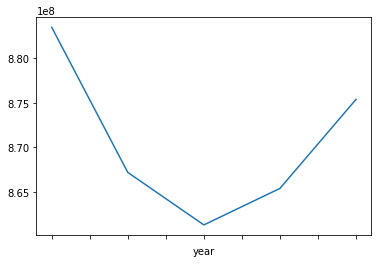

In [79]:
indicators_df.groupby("year").undernourishment.sum().plot();

The undernutrition decreases from 2013 to 2015, then started increasing again from 2015 to 2017.

### 6.2 Projected population size in 2050

In [80]:
# Find all the country with aggregated value
population.query("Flag == 'A'").Country.unique()

array(['China'], dtype=object)

China is the only country with Aggregate in the dataframe, we will remove it for all the years

In [81]:
# We use population_df and remove China 
population_df = population_df.query("Country != 'China'")
population_reg = population.groupby("Year").population.sum().reset_index()
population_reg.head(2)

,Year,population
0,1961,3.722932e+09
1,1962,3.791410e+09


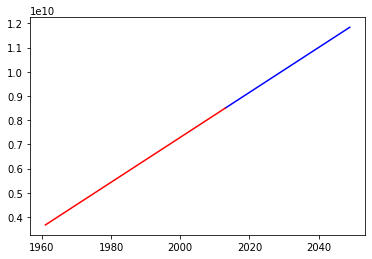

In [82]:
# Prediction of the population 
reg = LinearRegression()
year = population_reg.Year.values.reshape(-1,1)
pop = population_reg.population.values.reshape(-1,1)
reg.fit(year, pop)
years = np.array(range(2013, 2050)).reshape(-1,1)
population_pred = reg.predict(years)
pop_pred = reg.predict(year)
plt.plot(years, population_pred, color = "blue")
plt.plot(year, pop_pred, color = "red");

The world population will be around 12 billion in 2050.

In [83]:
# Create a new folder to save the files in
if not os.path.exists("clean_files"):
    os.makedirs("clean_files")
# Save all the files for future use
food_balance.to_csv("clean_files/food_balance.csv")
population_df.to_csv("clean_files/population_clean.csv")
indicators_df.to_csv("clean_files/security_indicators.csv")